In [1]:
import torch
import torchvision
from torch import nn, optim
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torch.nn import Conv2d, Linear
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torchvision.models import SqueezeNet1_1_Weights



In [2]:
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Crop the center of the image
    transforms.Resize((64, 64)),  # Resize the image to (64, 64)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

In [3]:
class MyCelebA(CelebA):
    def _check_integrity(self) -> bool:
        return True

In [4]:
np.random.seed(42)

celeba_train = MyCelebA(root='.', split='train', transform=transform, download=False)
celeba_test = MyCelebA(root='.', split='test', transform=transform, download=False)
celeba_valid = MyCelebA(root='.', split='valid', transform=transform, download=False)


In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU or CPU for training
print(device)

cuda


In [6]:
celeba_train = list(celeba_train)

for i in range(len(celeba_train)):
    elem = list(celeba_train[i])
    elem[1] = elem[1][20]
    celeba_train[i] = tuple(elem)

count_eyeglasses_train = sum(tensor[1].eq(1).sum().item() for tensor in celeba_train)
print("Statistics train dataset eyeglasses to all: ", count_eyeglasses_train, "/",len(celeba_train))    
    
celeba_test = list(celeba_test)

for i in range(len(celeba_test)):
    elem = list(celeba_test[i])
    elem[1] = elem[1][20]
    celeba_test[i] = tuple(elem)
    
count_of_ones = sum(tensor[1].eq(1).sum().item() for tensor in celeba_test)
print("Statistics test dataset eyeglasses to all: ", count_of_ones, "/",len(celeba_test))

celeba_valid = list(celeba_valid)

for i in range(len(celeba_valid)):
    elem = list(celeba_valid[i])
    elem[1] = elem[1][20]
    celeba_valid[i] = tuple(elem)
    
count_of_ones = sum(tensor[1].eq(1).sum().item() for tensor in celeba_valid)
print("Statistics valid dataset eyeglasses to all: ", count_of_ones, "/",len(celeba_valid))

Statistics train dataset eyeglasses to all:  68261 / 162770
Statistics test dataset eyeglasses to all:  7715 / 19962
Statistics valid dataset eyeglasses to all:  8458 / 19867


In [7]:
count_no_eyeglasses = len(celeba_train) - count_eyeglasses_train

weight_for_no_eyeglasses = len(celeba_train) / (2 * count_no_eyeglasses)
print(weight_for_no_eyeglasses)
weight_for_eyeglasses = len(celeba_train) / (2 * count_eyeglasses_train)
print(weight_for_eyeglasses)

0.8611349183675628
1.1922620530024466


In [8]:
train_loader = torch.utils.data.DataLoader(celeba_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(celeba_test, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(celeba_valid, batch_size=64, shuffle=True)

In [9]:
class SqueezeNetBinary(nn.Module):
    def __init__(self):
        super(SqueezeNetBinary, self).__init__()
        self.features = torchvision.models.squeezenet1_1(weights=SqueezeNet1_1_Weights.DEFAULT).features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 2),  
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
attributes = pd.read_csv("celeba/list_attr_celeba.csv")

In [11]:
attributes.head(10).style

,File_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [12]:
list(attributes.columns.values.tolist())[21]

'Male'

In [13]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)

        correct_predictions += torch.sum(preds == labels.data)

    return running_loss / len(train_loader.dataset), correct_predictions.double() / len(train_loader.dataset)

In [14]:
# Function to evaluate the model on the validation set
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    return running_loss / len(val_loader.dataset), correct_predictions.double() / len(val_loader.dataset)

In [15]:
# Initialize the model, criterion, and optimizer
model = SqueezeNetBinary().to(device)
class_weights = torch.tensor([weight_for_no_eyeglasses, weight_for_eyeglasses]).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [16]:
model

SqueezeNetBinary(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Max

In [17]:

# Function to train the model with early stopping
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch + 1} epochs without improvement.')
            break

    # Plotting the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Train and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    #Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
    plt.title('Train and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/20, Train Loss: 0.0062, Train Acc: 0.9093, Val Loss: 0.0057, Val Acc: 0.9498
Epoch 2/20, Train Loss: 0.0057, Train Acc: 0.9449, Val Loss: 0.0055, Val Acc: 0.9591
Epoch 3/20, Train Loss: 0.0056, Train Acc: 0.9541, Val Loss: 0.0055, Val Acc: 0.9633
Epoch 4/20, Train Loss: 0.0055, Train Acc: 0.9589, Val Loss: 0.0054, Val Acc: 0.9658
Epoch 5/20, Train Loss: 0.0054, Train Acc: 0.9631, Val Loss: 0.0054, Val Acc: 0.9672
Epoch 6/20, Train Loss: 0.0054, Train Acc: 0.9655, Val Loss: 0.0054, Val Acc: 0.9658
Epoch 7/20, Train Loss: 0.0054, Train Acc: 0.9675, Val Loss: 0.0054, Val Acc: 0.9668
Epoch 8/20, Train Loss: 0.0054, Train Acc: 0.9693, Val Loss: 0.0053, Val Acc: 0.9710
Epoch 9/20, Train Loss: 0.0053, Train Acc: 0.9715, Val Loss: 0.0054, Val Acc: 0.9723
Epoch 10/20, Train Loss: 0.0053, Train Acc: 0.9730, Val Loss: 0.0053, Val Acc: 0.9709
Epoch 11/20, Train Loss: 0.0053, Train Acc: 0.9744, Val Loss: 0.0053, Val Acc: 0.9687
Epoch 12/20, Train Loss: 0.0053, Train Acc: 0.9757, Val Loss: 0

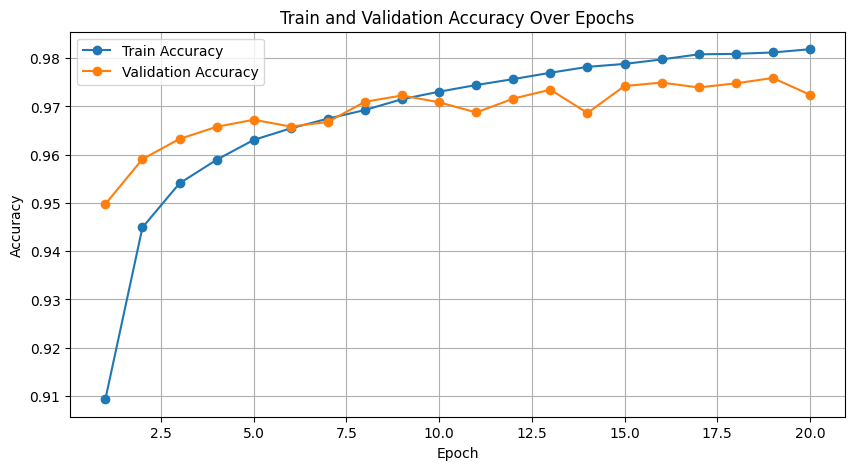

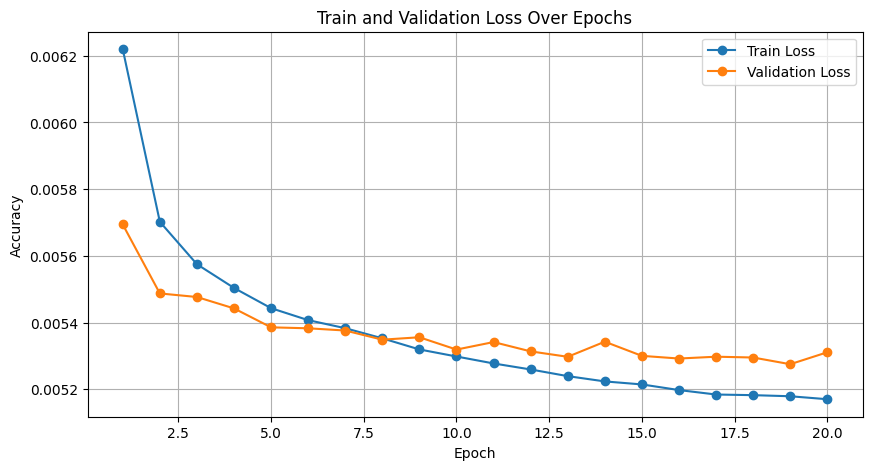

In [18]:
import matplotlib.pyplot as plt
train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, 20, 20)

In [23]:
# Specify the file path to save the model
save_path = 'squeezenet_model_is_male_newest_weights.pth'

# Save the entire model (including architecture, parameters, and optimizer state)
torch.save(model.state_dict(), save_path)

In [20]:
loaded_model = torch.load('squeezenet_model_is_male_10_weights.pth', map_location=torch.device('cpu'))


In [21]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, data_loader, print_confusion_matrix=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    print(f'Weighted Precision: {precision:.4f}')
    print(f'Weighted Recall: {recall:.4f}')
    print(f'Weighted F1 Score: {f1:.4f}')

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    print(f'Macro Precision: {precision_macro:.4f}')
    print(f'Macro Recall: {recall_macro:.4f}')
    print(f'Macro F1 Score: {f1_macro:.4f}')

    
    if print_confusion_matrix:
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Male", "Male"], yticklabels=["Not Male", "Male"])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

Accuracy: 0.9659
Weighted Precision: 0.9660
Weighted Recall: 0.9659
Weighted F1 Score: 0.9659
Macro Precision: 0.9630
Macro Recall: 0.9654
Macro F1 Score: 0.9641


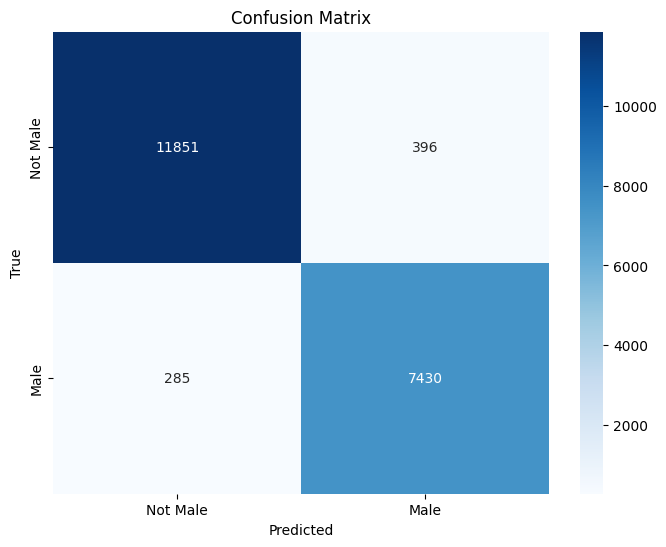

In [22]:
evaluate_model(model, test_loader)
